# Resimulation analysis

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pandas.plotting import parallel_coordinates
from matplotlib.lines import Line2D

In [2]:
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from model.model_nile import ModelNile
from model.model_nile_scenario import ModelNileScenario
from experimentation.data_generation import generate_input_data
from plotter import HydroModelPlotter

Read the results of the open exploration:

In [3]:
experiments = pd.read_csv("../outputs/experiments_resimulation.csv").drop(
    columns="Unnamed: 0"
)
outcomes = pd.read_csv("../outputs/outcomes_resimulation.csv").drop(
    columns="Unnamed: 0"
)

In [4]:
experiments

,yearly_demand_growth_rate,blue_nile_mean_coef,white_nile_mean_coef,atbara_mean_coef,blue_nile_dev_coef,white_nile_dev_coef,atbara_dev_coef,uniform_flag,v0,v1,...,v157,v158,v159,v160,v161,v162,v163,scenario,policy,model
0,0.02,1.00,1.00,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,Baseline,Policy0,NileProblem
1,0.02,1.00,1.00,1.0,1.0,1.0,1.0,-1.0,0.031535,0.337122,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,OptimScen,Policy0,NileProblem
2,0.03,0.75,1.00,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,HighD_LowB,Policy0,NileProblem
3,0.03,1.00,0.75,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,HighD_LowWh,Policy0,NileProblem
4,0.02,1.25,1.00,1.0,1.0,1.0,1.0,1.0,0.031535,0.337122,...,0.077558,0.430239,0.258722,0.211918,0.766847,0.212388,0.164798,HighB,Policy0,NileProblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,0.02,1.00,1.00,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,Baseline,Policy849,NileProblem
4246,0.02,1.00,1.00,1.0,1.0,1.0,1.0,-1.0,0.033142,0.337786,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,OptimScen,Policy849,NileProblem
4247,0.03,0.75,1.00,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,HighD_LowB,Policy849,NileProblem
4248,0.03,1.00,0.75,1.0,1.0,1.0,1.0,1.0,0.033142,0.337786,...,0.134853,0.463012,0.880641,0.213401,0.273740,0.654365,0.715620,HighD_LowWh,Policy849,NileProblem


In [5]:
# merged_df = pd.merge(experiments,outcomes, left_index=True, right_index=True)
# levers = [f"v{i}" for i in range(164)]
# objs = list(outcomes.columns)
# merged_df.loc[merged_df["scenario"] == "OptimScen", levers + objs].reset_index().drop(columns = "index").to_csv("../outputs/baseline_results1.csv",index=True)

In [6]:
def normalize_objs(df, directions):
    desirability_couples = list()
    working_df = df.copy()
    for i, col in enumerate(df.columns):
        if directions[i] == "min":
            best, worst = df[col].min(), df[col].max()
        elif directions[i] == "max":
            best, worst = df[col].max(), df[col].min()
        desirability_couples.append((worst, best))
        working_df[col] = (df[col] - worst) / (best - worst)

    return working_df, desirability_couples

In [7]:
from scipy.stats import linregress

In [8]:
scenario_indexes = {
    scen: list(experiments.loc[experiments["scenario"] == scen].index)
    for scen in experiments["scenario"].unique()
}
slope_dfs = {}
corr_dfs = {}


def m3s_to_bcm_per_year(x):
    return x * 3600 * 24 * 365 * 1e-9 / 20


for scen, indexes in scenario_indexes.items():
    print("---------------------------------")
    print(scen)
    print("---------------------------------")
    norm_df, desire_couples = normalize_objs(
        outcomes.loc[indexes],
        ["min", "min", "min", "min", "min", "max"]
        # outcomes.loc[indexes], ["max", "max", "max", "max", "max", "max"]
    )
    # norm_df = outcomes.loc[indexes]

    cor_template = norm_df.corr()
    reg_template = cor_template.copy()
    for name1 in cor_template.columns:
        for name2 in cor_template.columns:
            if name1 == name2:
                cor_template.at[name1, name2] = None
            if name1 == "sudan_90" or name2 == "sudan_90":
                cor_template.at[name1, name2] = None
                reg_template.at[name1, name2] = None
            if cor_template.loc[name1, name2] is None:
                continue

            slope, intercept, r_value, p_value, std_err = linregress(
                x=norm_df[name1], y=norm_df[name2]
            )
            if reg_template.at[name1, name2] == cor_template.at[name1, name2]:
                reg_template.at[name1, name2] = slope
                reg_template.at[name2, name1] = slope

            # dif_series = abs(norm_df[name1] - norm_df[name2])
            # cor_template.at[name1,name2] = dif_series.mean()

    slope_dfs[scen] = reg_template
    corr_dfs[scen] = cor_template

    #     norm_df["class"] = "solutions"
    #     fig, ax = plt.subplots()
    #     parallel_coordinates(norm_df, "class", ax=ax)
    #     ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    #     plt.show()
    #     corr_df = outcomes.loc[indexes].corr()
    #     print(corr_df)
    #     mask = np.triu(np.ones_like(corr_df, dtype=np.bool))
    #     sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    #     sns.pairplot(outcomes.loc[indexes])
    unit_adjusted = outcomes.loc[indexes].copy()
    unit_adjusted.egypt_irr = m3s_to_bcm_per_year(unit_adjusted.egypt_irr)
    unit_adjusted.sudan_irr = m3s_to_bcm_per_year(unit_adjusted.sudan_irr)
    print(unit_adjusted.loc[indexes].describe())

---------------------------------
Baseline
---------------------------------
        egypt_irr    egypt_90  egypt_low_had  sudan_irr  sudan_90  \
count  850.000000  850.000000          850.0      850.0     850.0   
mean    47.648269  549.238355            0.0        0.0       0.0   
std      4.910901   54.013411            0.0        0.0       0.0   
min     24.792882  292.771026            0.0        0.0       0.0   
25%     46.707977  558.490953            0.0        0.0       0.0   
50%     48.586302  573.091517            0.0        0.0       0.0   
75%     49.893282  575.795714            0.0        0.0       0.0   
max     59.103055  636.868462            0.0        0.0       0.0   

       ethiopia_hydro  
count      850.000000  
mean        13.141593  
std          0.161581  
min         11.185533  
25%         13.163773  
50%         13.167186  
75%         13.168484  
max         13.169542  
---------------------------------
OptimScen
---------------------------------
       

In [9]:
slope, intercept, r_value, p_value, std_err = linregress(
    x=outcomes["egypt_90"], y=outcomes["egypt_irr"]
)
1 / slope

0.011834442268204255

In [10]:
pd.set_option("precision", 2)

In [11]:
slope_dfs["Baseline"].dropna(axis=0, how="all").dropna(
    axis=1, how="all"
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,ethiopia_hydro
egypt_irr,1.00,0.95,-0.05
egypt_90,0.95,1.00,-0.04
ethiopia_hydro,-0.05,-0.04,1.00


In [12]:
corr_dfs["Baseline"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(
    1
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,ethiopia_hydro
egypt_irr,1.00,0.87,-0.08
egypt_90,0.87,1.00,-0.08
ethiopia_hydro,-0.08,-0.08,1.00


In [13]:
slope_dfs["HighD_LowB"].dropna(axis=0, how="all").dropna(
    axis=1, how="all"
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.85,-0.62,-0.36,-0.29
egypt_90,0.85,1.00,-0.68,-0.31,-0.24
egypt_low_had,-0.62,-0.68,1.00,-0.05,-0.13
sudan_irr,-0.36,-0.31,-0.05,1.00,0.98
ethiopia_hydro,-0.29,-0.24,-0.13,0.98,1.00


In [14]:
corr_dfs["HighD_LowB"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(
    1
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.95,-0.56,-0.38,-0.30
egypt_90,0.95,1.00,-0.55,-0.30,-0.22
egypt_low_had,-0.56,-0.55,1.00,-0.06,-0.15
sudan_irr,-0.38,-0.30,-0.06,1.00,0.96
ethiopia_hydro,-0.30,-0.22,-0.15,0.96,1.00


In [15]:
slope_dfs["HighD_LowWh"].dropna(axis=0, how="all").dropna(
    axis=1, how="all"
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.94,-0.08,-0.21
egypt_90,0.94,1.00,-0.07,-0.20
sudan_irr,-0.08,-0.07,1.00,1.12
ethiopia_hydro,-0.21,-0.20,1.12,1.00


In [16]:
corr_dfs["HighD_LowWh"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(
    1
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.93,-0.22,-0.24
egypt_90,0.93,1.00,-0.19,-0.23
sudan_irr,-0.22,-0.19,1.00,0.45
ethiopia_hydro,-0.24,-0.23,0.45,1.00


In [17]:
slope_dfs["HighB"].dropna(axis=0, how="all").dropna(
    axis=1, how="all"
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,ethiopia_hydro
egypt_irr,1.00,0.90,0.02
egypt_90,0.90,1.00,0.08
ethiopia_hydro,0.02,0.08,1.00


In [52]:
corr_dfs["HighB"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(
    1
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,ethiopia_hydro
egypt_irr,1.00,0.95,0.03
egypt_90,0.95,1.00,0.09
ethiopia_hydro,0.03,0.09,1.00


In [53]:
slope_dfs["OptimScen"].drop(columns="sudan_90").drop(index="sudan_90").dropna(
    axis=0, how="all"
).dropna(axis=1, how="all").style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.77,-0.58,-0.23,-0.28
egypt_90,0.77,1.00,-0.94,-0.13,-0.29
egypt_low_had,-0.58,-0.94,1.00,-0.06,-0.01
sudan_irr,-0.23,-0.13,-0.06,1.00,0.71
ethiopia_hydro,-0.28,-0.29,-0.01,0.71,1.00


In [54]:
corr_dfs["OptimScen"].dropna(axis=0, how="all").dropna(axis=1, how="all").fillna(
    1
).style.background_gradient(axis=None, vmin=0, vmax=1)

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,ethiopia_hydro
egypt_irr,1.00,0.82,-0.51,-0.29,-0.38
egypt_90,0.82,1.00,-0.78,-0.16,-0.37
egypt_low_had,-0.51,-0.78,1.00,-0.09,-0.01
sudan_irr,-0.29,-0.16,-0.09,1.00,0.75
ethiopia_hydro,-0.38,-0.37,-0.01,0.75,1.00


In [20]:
def parallel_plots(
    obj_df,
    solution_indices=[],
    solution_names=[],
    directions=["min", "min", "min", "min", "max"],
    names_display=[
        "Egypt Irr. Deficit",
        "Egypt $90^{th}$ Irr. Deficit",
        "Egypt Low HAD",
        "Sudan Irr. Deficit",
        "Ethiopia Hydropower",
    ],
    units=["BCM/year", "m3/s", "%", "BCM/year", "TWh/year"],
    colors=["#bdbdbd"],
):
    file_name = "Best_objectives"

    names = list(obj_df.columns)

    objectives_df = obj_df.copy()
    objectives_df.egypt_irr = m3s_to_bcm_per_year(objectives_df.egypt_irr)
    # objectives_df.sudan_irr = m3s_to_bcm_per_year(objectives_df.sudan_irr)
    # objectives_df.egypt_low_had = 100*(objectives_df.egypt_low_had)

    norm_df, desirability_couples = normalize_objs(objectives_df, directions)

    uds = []  # undesired
    ds = []  # desired
    for i in desirability_couples:
        uds.append(str(round(i[0], 1)))
        ds.append(str(round(i[1], 1)))

    norm_df["Name"] = "All Solutions"

    if solution_indices == []:
        for i, col_name in enumerate(names):
            solution_index = norm_df.loc[norm_df[col_name] == 1, :].index
            norm_df.loc[solution_index, "Name"] = f"Best {names_display[i]}"
            norm_df = norm_df.append(norm_df.loc[solution_index, :].copy())

    else:
        for i, solution_index in enumerate(solution_indices):
            norm_df.loc[solution_index, "Name"] = solution_names[i]
            norm_df = norm_df.append(norm_df.loc[solution_index, :].copy())

    fig = plt.figure()

    ax1 = fig.add_subplot(111)

    parallel_coordinates(norm_df, "Name", color=colors, linewidth=7, alpha=0.8)
    plt.legend(
        bbox_to_anchor=(0.0, 1.02, 1.0, 0.102),
        loc=3,
        ncol=4,
        mode="expand",
        borderaxespad=1.5,
        fontsize=18,
    )

    ax1.set_xticks(np.arange(len(names)))

    ax1.set_xticklabels(
        [
            uds[i] + "\n" + "\n" + names_display[i] + "\n[" + units[i] + "]"
            for i in range(len(names))
        ],
        fontsize=18,
    )
    ax2 = ax1.twiny()
    ax2.set_xticks(np.arange(len(names)))
    ax2.set_xticklabels([ds[i] for i in range(len(names))], fontsize=18)

    ax1.get_yaxis().set_visible([])
    plt.text(
        1.02,
        0.5,
        "Direction of Preference $\\rightarrow$",
        {"color": "#636363", "fontsize": 20},
        horizontalalignment="left",
        verticalalignment="center",
        rotation=90,
        clip_on=False,
        transform=plt.gca().transAxes,
    )

    fig.set_size_inches(25, 12)
    plt.show()

In [21]:
gray = "#bdbdbd"
purple = "#7a0177"
green = "#41ab5d"
blue = "#1d91c0"
yellow = "#fdaa09"
pink = "#c51b7d"

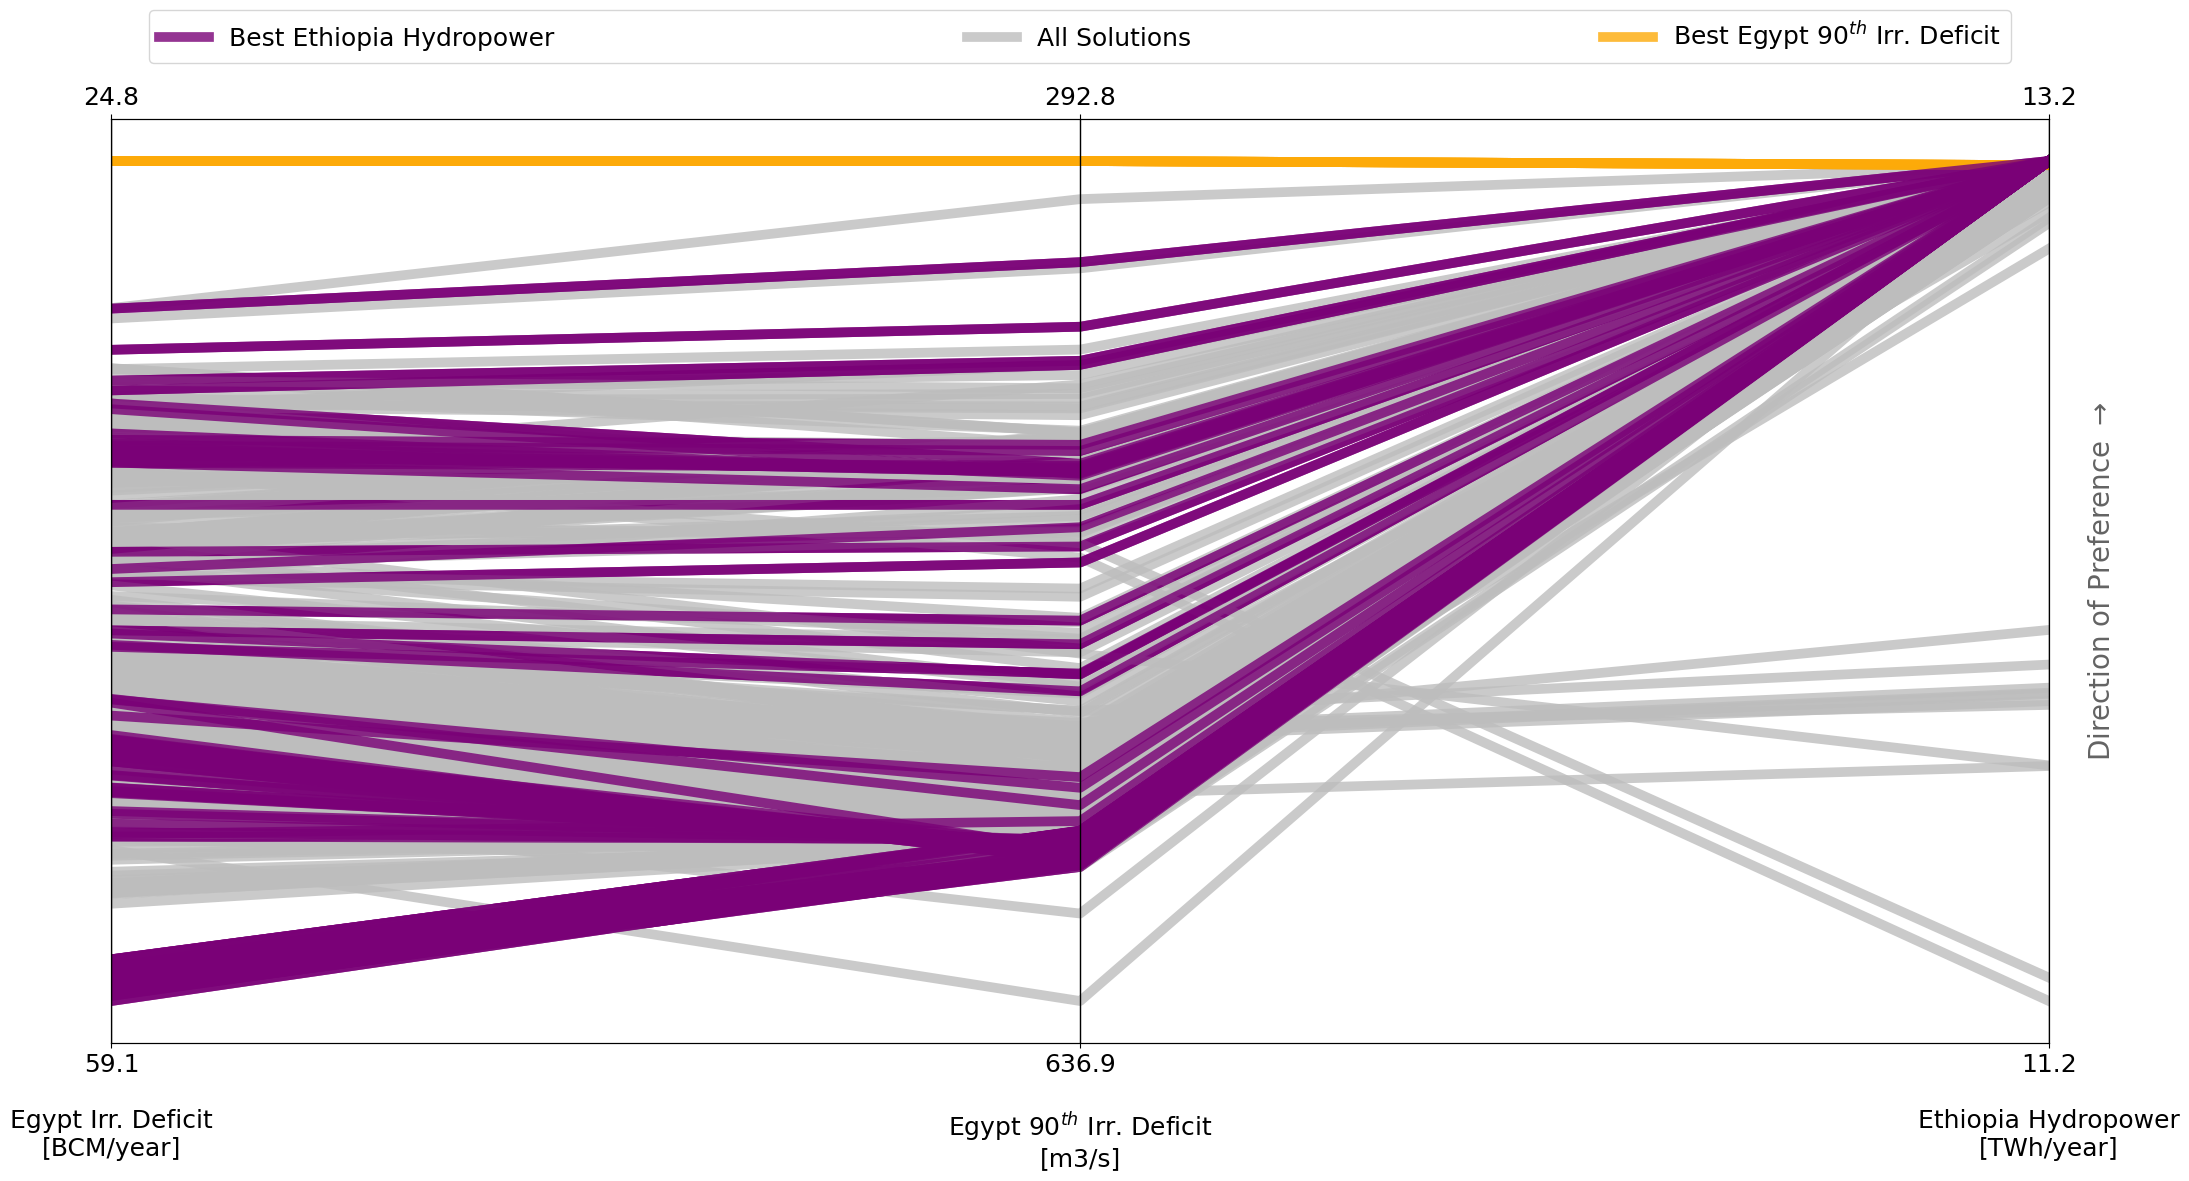

In [22]:
parallel_plots(
    outcomes.loc[
        scenario_indexes["Baseline"], ["egypt_irr", "egypt_90", "ethiopia_hydro"]
    ],
    directions=["min", "min", "max"],
    names_display=[
        "Egypt Irr. Deficit",
        "Egypt $90^{th}$ Irr. Deficit",
        "Ethiopia Hydropower",
    ],
    units=["BCM/year", "m3/s", "TWh/year"],
    colors=[purple, gray, yellow],
)

In [23]:
outcomes.loc[scenario_indexes["Baseline"], ["egypt_irr", "egypt_90", "ethiopia_hydro"]],
names_display = (
    ["Egypt Irr. Deficit", "Egypt $90^{th}$ Irr. Deficit", "Ethiopia Hydropower"],
)

In [24]:
outcomes.loc[scenario_indexes["HighD_LowB"]].columns

Index(['egypt_irr', 'egypt_90', 'egypt_low_had', 'sudan_irr', 'sudan_90',
       'ethiopia_hydro'],
      dtype='object')

In [25]:
from scipy.stats import linregress


def r2(x, y, ax=None, **kws):
    ax = ax or plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x=x, y=y)
    ax.annotate(
        f"$r^2 = {r_value ** 2:.2f}$\nEq: ${slope:.2f}x{intercept:+.2f}$",
        xy=(0.05, 0.95),
        xycoords=ax.transAxes,
        fontsize=8,
        color="darkred",
        backgroundcolor="#FFFFFF99",
        ha="left",
        va="top",
    )

In [50]:
# sns.pairplot(normalize_objs(outcomes.loc[scenario_indexes["Baseline"],['egypt_irr', 'egypt_90', 'ethiopia_hydro']],
#                             directions=["min", "min","max"])[0],
#              corner=True, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}})


sns.pairplot(
    normalize_objs(
        outcomes.loc[
            scenario_indexes["OptimScen"],
            ["egypt_irr", "egypt_90", "egypt_low_had", "sudan_irr", "ethiopia_hydro"],
        ],
        directions=["min", "min", "min", "min", "max"],
    )[0],
    corner=True,
    kind="reg",
    diag_kind="kde",
    plot_kws={"line_kws": {"color": "red"}},
)

# g = sns.pairplot(normalize_objs(outcomes.loc[scenario_indexes["HighD_LowWh"],['egypt_irr', 'egypt_90', 'sudan_irr','ethiopia_hydro']],
#                             directions=["min", "min","min","max"])[0],
#              corner=True, kind="reg", diag_kind= "kde",plot_kws={'line_kws':{'color':'red'}})
# g.axes[3,0].set_xlim((0,1))
# g.axes[3,0].set_ylim((0,1.2))

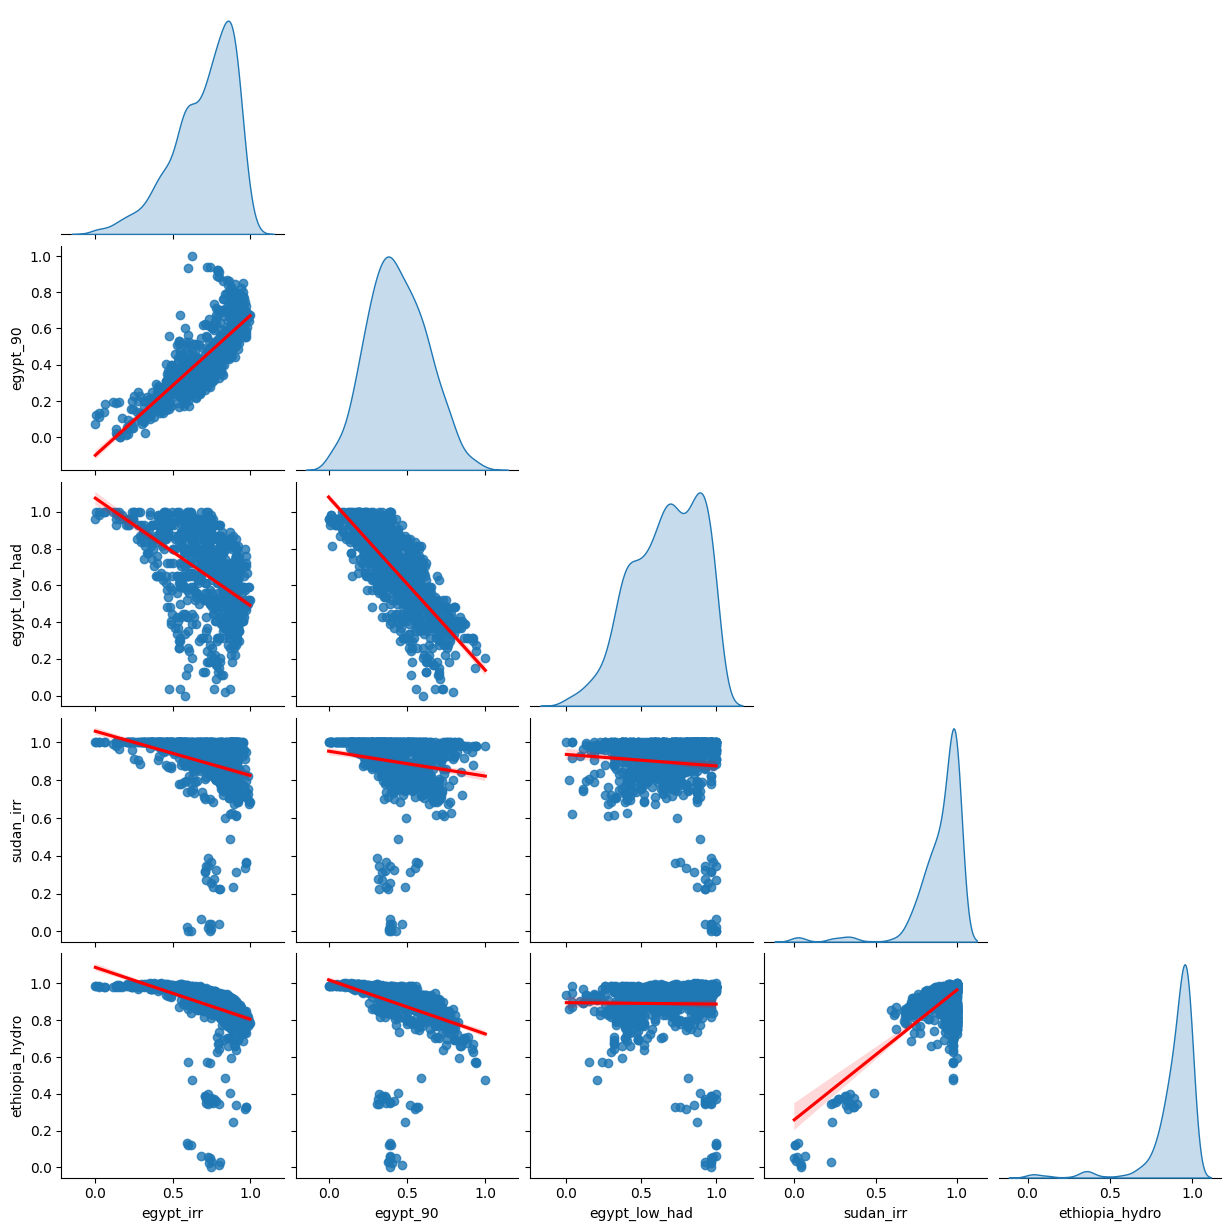

In [51]:
plt.show()

In [28]:
sns.pairplot(
    normalize_objs(
        outcomes.loc[
            scenario_indexes["HighD_LowWh"],
            ["egypt_irr", "egypt_90", "sudan_irr", "ethiopia_hydro"],
        ],
        directions=["min", "min", "min", "max"],
    )[0].drop(columns="egypt_low_had"),
    corner=True,
)

KeyError: "['egypt_low_had'] not found in axis"

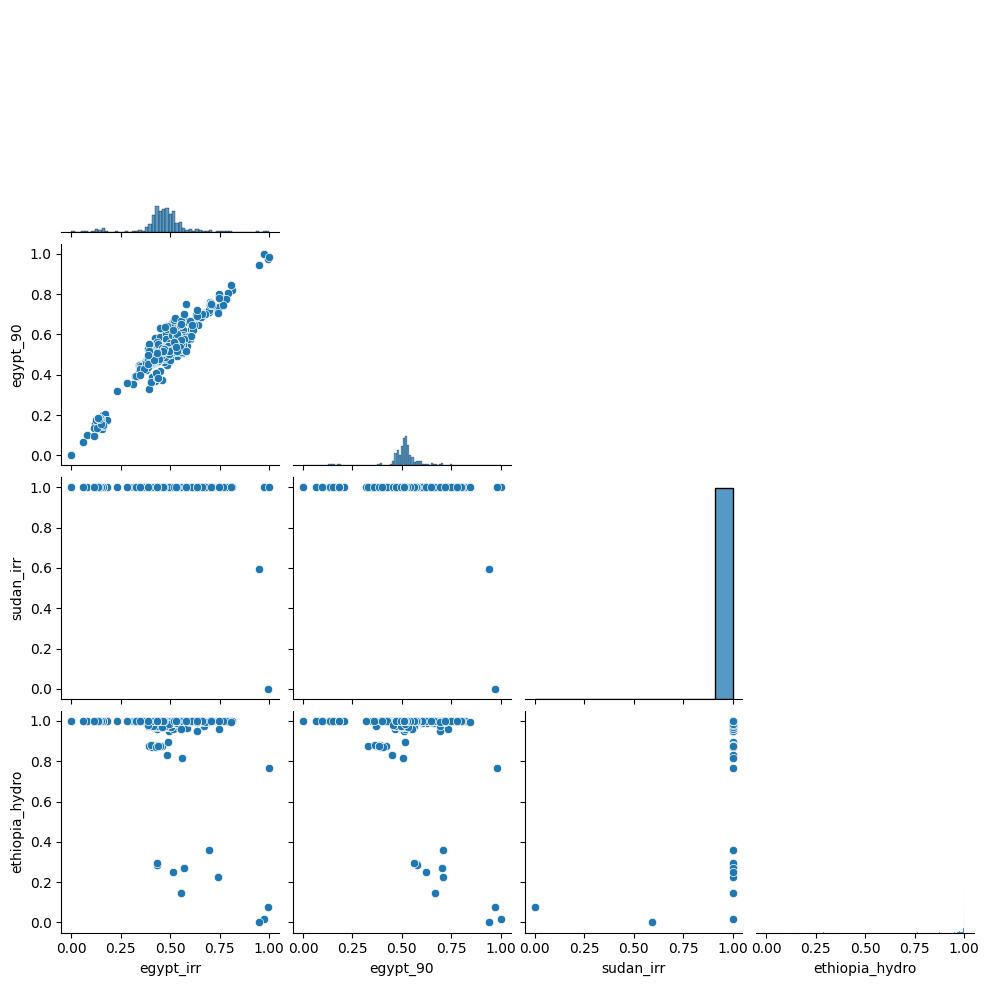

In [46]:
plt.show()

In [ ]:
names_display = [
    "Egypt Irr. Deficit",
    "Egypt $90^{th}$ Irr. Deficit",
    "Egypt Low HAD",
    "Sudan Irr. Deficit",
    "Ethiopia Hydropower",
]
norm_df_names = norm_df.copy()
norm_df_names.columns = names_display
sns.pairplot(
    norm_df_names, corner=True, kind="reg", plot_kws={"line_kws": {"color": "red"}}
)

In [14]:
normed_df = normalize_objs(
    outcomes.loc[scenario_indexes["Baseline"]],
    ["min", "min", "min", "min", "min", "max"],
)[0]
cor_template = normed_df.corr()
cor_template

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
egypt_irr,1.00,0.87,NaN,NaN,NaN,-0.08
egypt_90,0.87,1.00,NaN,NaN,NaN,-0.08
egypt_low_had,NaN,NaN,NaN,NaN,NaN,NaN
sudan_irr,NaN,NaN,NaN,NaN,NaN,NaN
sudan_90,NaN,NaN,NaN,NaN,NaN,NaN
ethiopia_hydro,-0.08,-0.08,NaN,NaN,NaN,1.00


In [15]:
for name1 in cor_template.columns:
    for name2 in cor_template.columns:
        if name1 == name2:
            continue
        if cor_template.loc[name1, name2] is None:
            continue
        dif_series = abs(normed_df[name1] - normed_df[name2])
        cor_template.at[name1, name2] = dif_series.mean()

In [16]:
cor_template

,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
egypt_irr,1.00,0.10,NaN,NaN,NaN,0.66
egypt_90,0.10,1.00,NaN,NaN,NaN,0.73
egypt_low_had,NaN,NaN,NaN,NaN,NaN,NaN
sudan_irr,NaN,NaN,NaN,NaN,NaN,NaN
sudan_90,NaN,NaN,NaN,NaN,NaN,NaN
ethiopia_hydro,0.66,0.73,NaN,NaN,NaN,1.00


In [17]:
import numpy as np

abs_dif = []
n = 50000
for _ in range(n):
    a = np.random.uniform()
    b = np.random.uniform()
    abs_dif.append(abs(a - b))

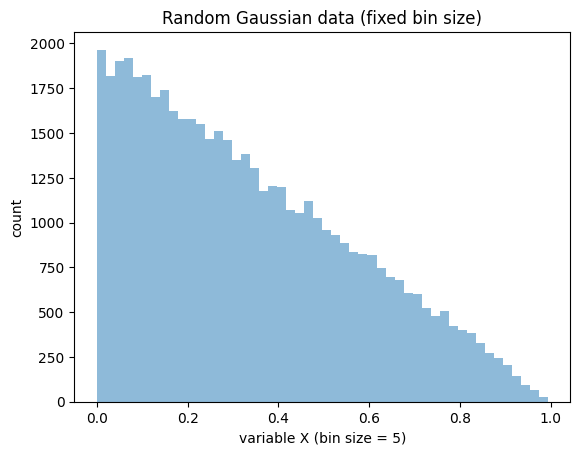

In [18]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = abs_dif

plt.hist(data, bins=50, alpha=0.5)
plt.title("Random Gaussian data (fixed bin size)")
plt.xlabel("variable X (bin size = 5)")
plt.ylabel("count")

plt.show()

In [19]:
import numpy as np

abs_list = []
n = 850
M = 1000

for i in range(M):
    abs_dif = 0
    for _ in range(n):
        a = np.random.triangular(0, 0, 1)
        abs_dif += a
    abs_list.append(abs_dif / n)

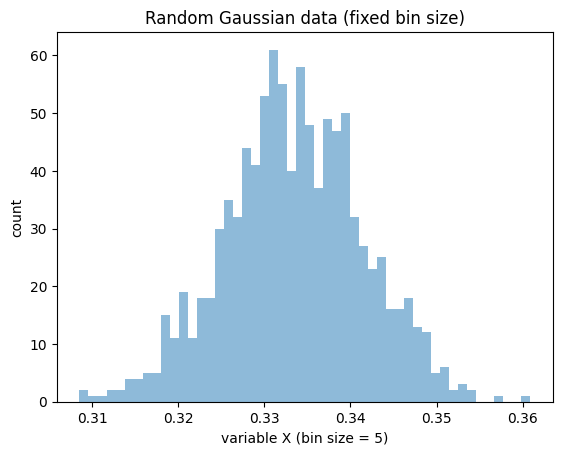

In [20]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = abs_list

plt.hist(data, bins=50, alpha=0.5)
plt.title("Random Gaussian data (fixed bin size)")
plt.xlabel("variable X (bin size = 5)")
plt.ylabel("count")

plt.show()